# Временные ряды
## Домашнее задание №5

<pre>
ФИО: Никифоров Владимир
</pre>

Выберите ряд (файл в приложении к заданию), на котором происходит аномалия. Примените к нему все 4 способа поиска анамолий.

In [88]:
import pandas as pd
import numpy as np
from collections import deque
from collections import defaultdict
from sklearn import svm

In [89]:
import matplotlib.pyplot as plt
import matplotlib.font_manager

%matplotlib inline

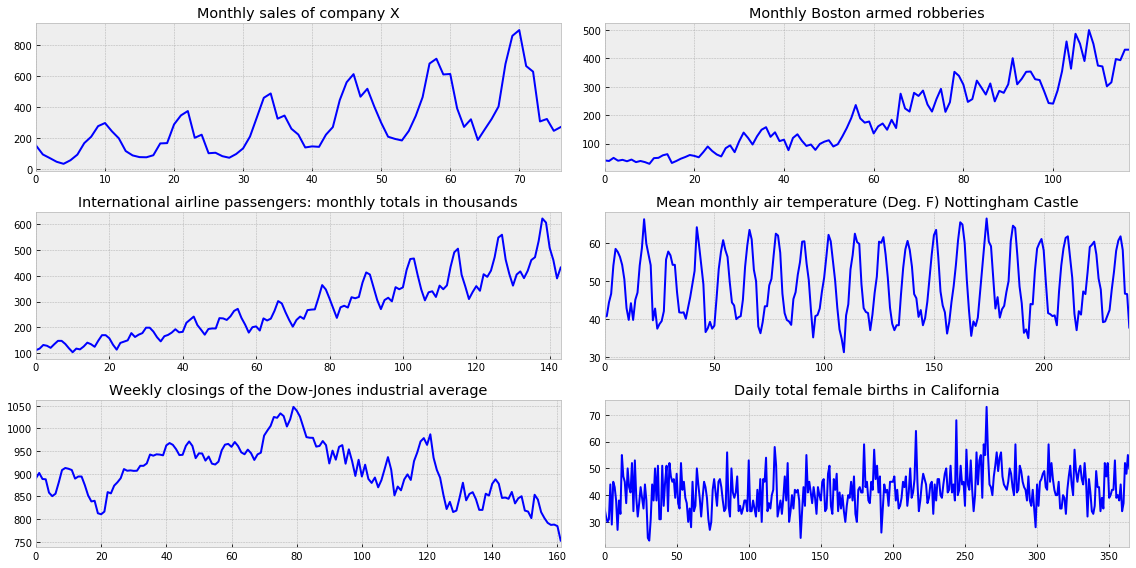

In [90]:
sales_of_company_x = pd.read_csv("../data/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("../data/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("../data/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("../data/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("../data/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("../data/daily-total-female-births-in-cal.csv")
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [91]:
class BaseDetector:
    def __init__(self, treshold=0.05):
        self.treshold = treshold
    
    def update(self, new_signal_value):
        pass
    
    def check(self, new_signal_value):
        pass
    
    def _plot(self, signal):
        stop_points = []
        for i, value in enumerate(signal):
            self.update(value)
            if self.check(value):
                stop_points.append(i)

        plt.figure(figsize=(16, 8))
        layout = (2, 2)
        plt.plot(signal, 'b.')
        plt.plot(signal, 'b-', alpha=0.15)
        plt.title(f'Series checking by: {self.__doc__}')

        if stop_points:
            #print(stop_points)
            for s in stop_points:
                plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                              colors='r', linestyles='dotted')

        plt.show()

In [92]:
class MeanDetector(BaseDetector):
    '''Обнаружение аномалий с использованием простого мат. ожидания'''
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

In [93]:
class ZScoreDetector(BaseDetector):
    '''Обнаружение аномалий с использованием движущегося окна и z-оценки'''
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

In [133]:
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

class CUSUMDetector(BaseDetector):
    '''Обнаружение аномалий с использованием метода кумулятивных сумм'''
    
    def __init__(self, x, threshold=1, drift=0, ending=False, ax=None):
        self.x = x
        self.threshold = threshold
        self.drift = drift
        self.ending = ending
        self.ax = ax
        self.ta = []
        self.tai = []
        self.gp = []

    def update(self, new_signal_value):
        """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

        Parameters
        ----------
        x : 1D array_like
            data.
        threshold : positive number, optional (default = 1)
            amplitude threshold for the change in the data.
        drift : positive number, optional (default = 0)
            drift term that prevents any change in the absence of change.
        ending : bool, optional (default = False)
            True (1) to estimate when the change ends; False (0) otherwise.
        show : bool, optional (default = True)
            True (1) plots data in matplotlib figure, False (0) don't plot.
        ax : a matplotlib.axes.Axes instance, optional (default = None).

        Returns
        -------
        ta : 1D array_like [indi, indf], int
            alarm time (index of when the change was detected).
        tai : 1D array_like, int
            index of when the change started.
        taf : 1D array_like, int
            index of when the change ended (if `ending` is True).
        amp : 1D array_like, float
            amplitude of changes (if `ending` is True).

        Notes
        -----
        Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
        Start with a very large `threshold`.
        Choose `drift` to one half of the expected change, or adjust `drift` such
        that `g` = 0 more than 50% of the time.
        Then set the `threshold` so the required number of false alarms (this can
        be done automatically) or delay for detection is obtained.
        If faster detection is sought, try to decrease `drift`.
        If fewer false alarms are wanted, try to increase `drift`.
        If there is a subset of the change times that does not make sense,
        try to increase `drift`.

        Note that by default repeated sequential changes, i.e., changes that have
        the same beginning (`tai`) are not deleted because the changes were
        detected by the alarm (`ta`) at different instants. This is how the
        classical CUSUM algorithm operates.

        If you want to delete the repeated sequential changes and keep only the
        beginning of the first sequential change, set the parameter `ending` to
        True. In this case, the index of the ending of the change (`taf`) and the
        amplitude of the change (or of the total amplitude for a repeated
        sequential change) are calculated and only the first change of the repeated
        sequential changes is kept. In this case, it is likely that `ta`, `tai`,
        and `taf` will have less values than when `ending` was set to False.

        See this IPython Notebook [2]_.

        References
        ----------
        .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
        .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

        Examples
        --------
        >>> from detect_cusum import detect_cusum
        >>> x = np.random.randn(300)/5
        >>> x[100:200] += np.arange(0, 4, 4/100)
        >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

        >>> x = np.random.randn(300)
        >>> x[100:200] += 6
        >>> detect_cusum(x, 4, 1.5, True, True)

        >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
        >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
        """

        self.x = np.atleast_1d(self.x).astype('float64')
        self.gp, self.gn = np.zeros(self.x.size), np.zeros(self.x.size)
        self.ta, self.tai, self.taf = np.array([[], [], []], dtype=int)
        tap, tan = 0, 0
        self.amp = np.array([])
        # Find changes (online form)
        for i in range(1, self.x.size):
            s = self.x[i] - self.x[i-1]
            self.gp[i] = self.gp[i-1] + s - self.drift  # cumulative sum for + change
            self.gn[i] = self.gn[i-1] - s - self.drift  # cumulative sum for - change
            if self.gp[i] < 0:
                self.gp[i], tap = 0, i
            if self.gn[i] < 0:
                self.gn[i], tan = 0, i
            if self.gp[i] > self.threshold or self.gn[i] > self.threshold:  # change detected!
                self.ta = np.append(self.ta, i)    # alarm index
                self.tai = np.append(self.tai, tap if self.gp[i] > self.threshold else tan)  # start
                self.gp[i], self.gn[i] = 0, 0      # reset alarm
        # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

        # Estimation of when the change ends (offline form)
        if self.tai.size and self.ending:
            _, tai2, _, _ = update(x[::-1], self.threshold, self.drift)
            self.taf = self.x.size - tai2[::-1] - 1
            # Eliminate repeated changes, changes that have the same beginning
            self.tai, ind = np.unique(self.tai, return_index=True)
            ta = ta[ind]
            if self.tai.size != self.taf.size:
                if self.tai.size < self.taf.size:
                    self.taf = self.taf[[np.argmax(self.taf >= i) for i in self.ta]]
                else:
                    ind = [np.argmax(i >= self.ta[::-1])-1 for i in self.taf]
                    self.ta = self.ta[ind]
                    self.tai = self.tai[ind]
            # Delete intercalated changes (the ending of the change is after
            # the beginning of the next change)
            ind = self.taf[:-1] - self.tai[1:] > 0
            if ind.any():
                self.ta = self.ta[~np.append(False, ind)]
                self.tai = self.tai[~np.append(False, ind)]
                self.taf = self.taf[~np.append(ind, False)]
            # Amplitude of changes
            amp = self.x[self.taf] - self.x[self.tai]

    def _plot(self):
        """Plot results of the detect_cusum function, see its help."""
        self.update(self.x)
        if self.ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8))

        t = range(self.x.size)
        ax1.plot(t, self.x, 'b-', lw=2)
        if len(self.ta):
            ax1.plot(self.tai, self.x[self.tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if self.ending:
                ax1.plot(self.taf, self.x[self.taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(self.ta, self.x[self.ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*self.x.size, self.x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = self.x[np.isfinite(self.x)].min(), self.x[np.isfinite(self.x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d \n%s'
                      % (self.threshold, self.drift, len(self.tai), self.__doc__))

        ax2.plot(t, self.gp, 'y-', label='+')
        ax2.plot(t, self.gn, 'm-', label='-')
        ax2.set_xlim(-.01*self.x.size, self.x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*self.threshold, 1.1*self.threshold)
        ax2.axhline(self.threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

In [127]:
class OneClassSVMDetector(BaseDetector):
    '''Обнаружение аномалий с использованием OneClass SVM классификатора'''
    def __init__(self, signal, y_train, y_test):
        self.signal = signal
        self.y_train = y_train.reshape(-1, 1)
        self.y_test = y_test.reshape(-1, 1)
        self.clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.01)
        self.clf.fit(self.y_train)
    
    def check(self, new_signal_value):
        return (self.clf.predict(new_signal_value.reshape(-1, 1)) == -1)
    
    def _plot(self, signal):
        stop_points = []
        for i, value in enumerate(self.signal):
            self.update(value)
            if self.check(value):
                stop_points.append(i)

        plt.figure(figsize=(16, 8))
        layout = (2, 2)
        plt.plot(self.signal, 'b.')
        plt.plot(self.signal, 'b-', alpha=0.15)
        plt.title(f'Series checking by: {self.__doc__}')

        if stop_points:
            #print(stop_points)
            for s in stop_points:
                plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                              colors='r', linestyles='dotted')

        plt.show()

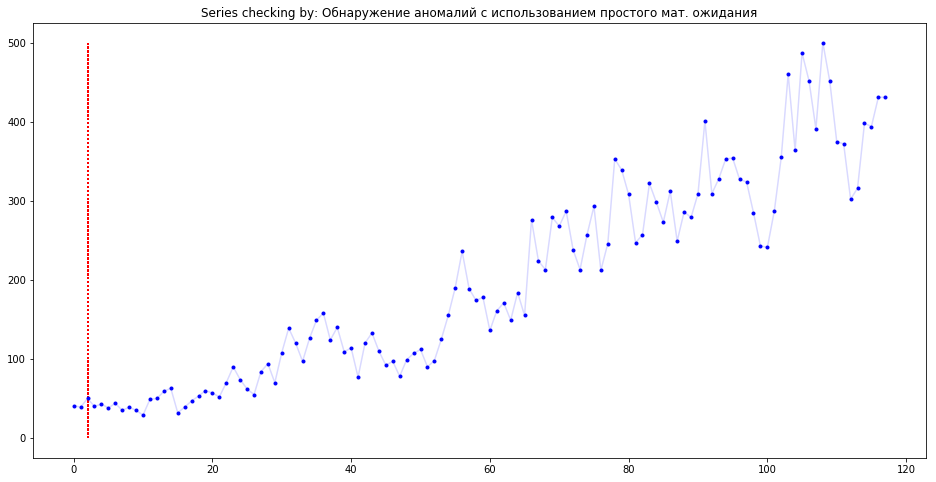

In [116]:
d = MeanDetector()
d._plot(robberies_in_boston["Count"])

/home/truename/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/home/truename/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


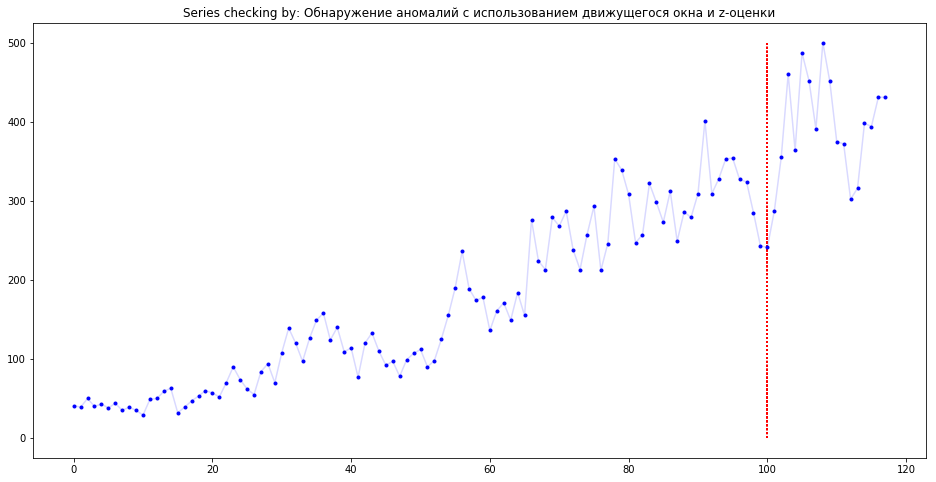

In [117]:
d = ZScoreDetector()
d._plot(robberies_in_boston["Count"])

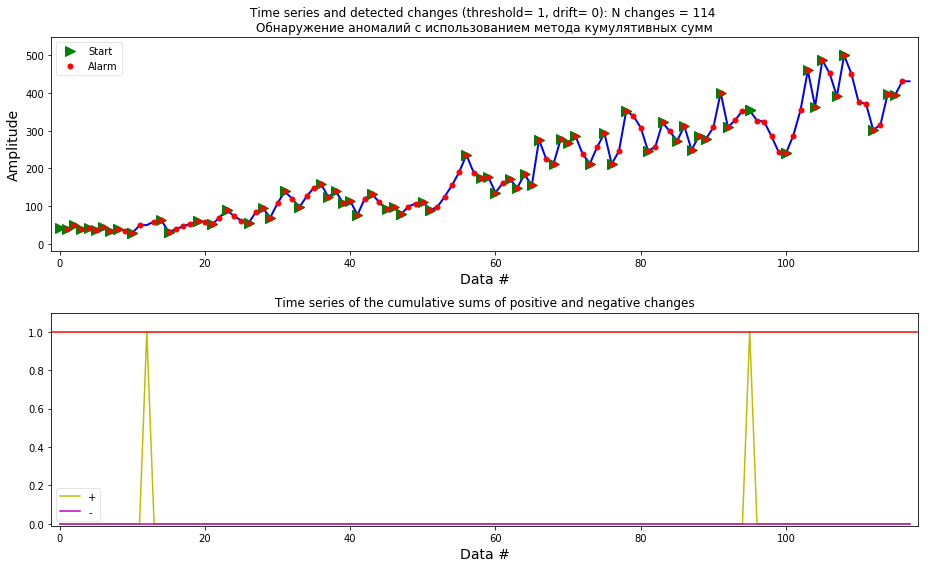

In [134]:
d = CUSUMDetector(robberies_in_boston["Count"])
d._plot()

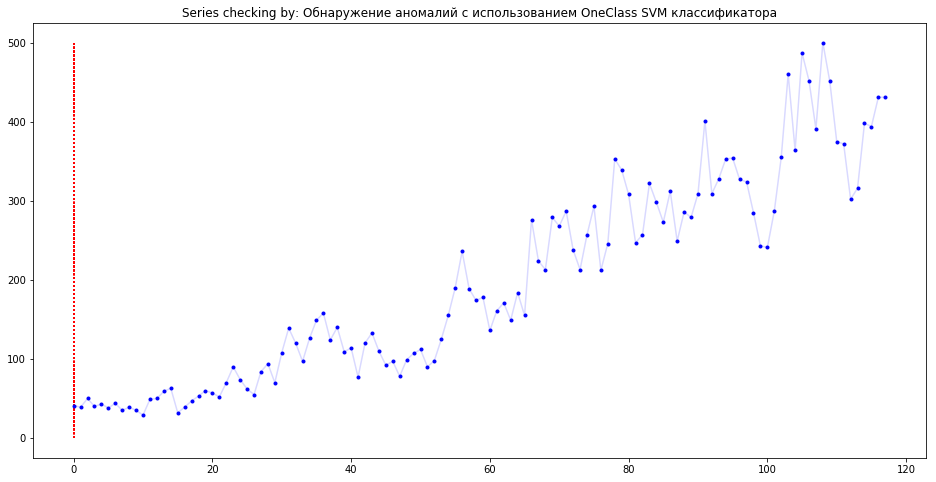

In [128]:
d = OneClassSVMDetector(robberies_in_boston["Count"].values, robberies_in_boston["Count"].values[:80],robberies_in_boston["Count"].values[80:])
d._plot(robberies_in_boston["Count"].values)